In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/amazon-walmart/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','amazon-walmart')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in data.keys():
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/amazon-walmart/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/amazon-walmart/glove-300.matrix.npy',
                        text_columns = ['brand', 'groupname', 'title', 'shelfdescr',
                                        'shortdescr', 'longdescr'],
                        numeric_columns = [],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=[],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False)

Number of inputs to dense layer: 6


# Train model 

In [46]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=128,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 93243 samples, validate on 11656 samples
Epoch 1/1
93243/93243 [==============================] - 31s 328us/step - loss: 0.0109 - acc: 0.9961 - val_loss: 0.0129 - val_acc: 0.9953


# Learning curves

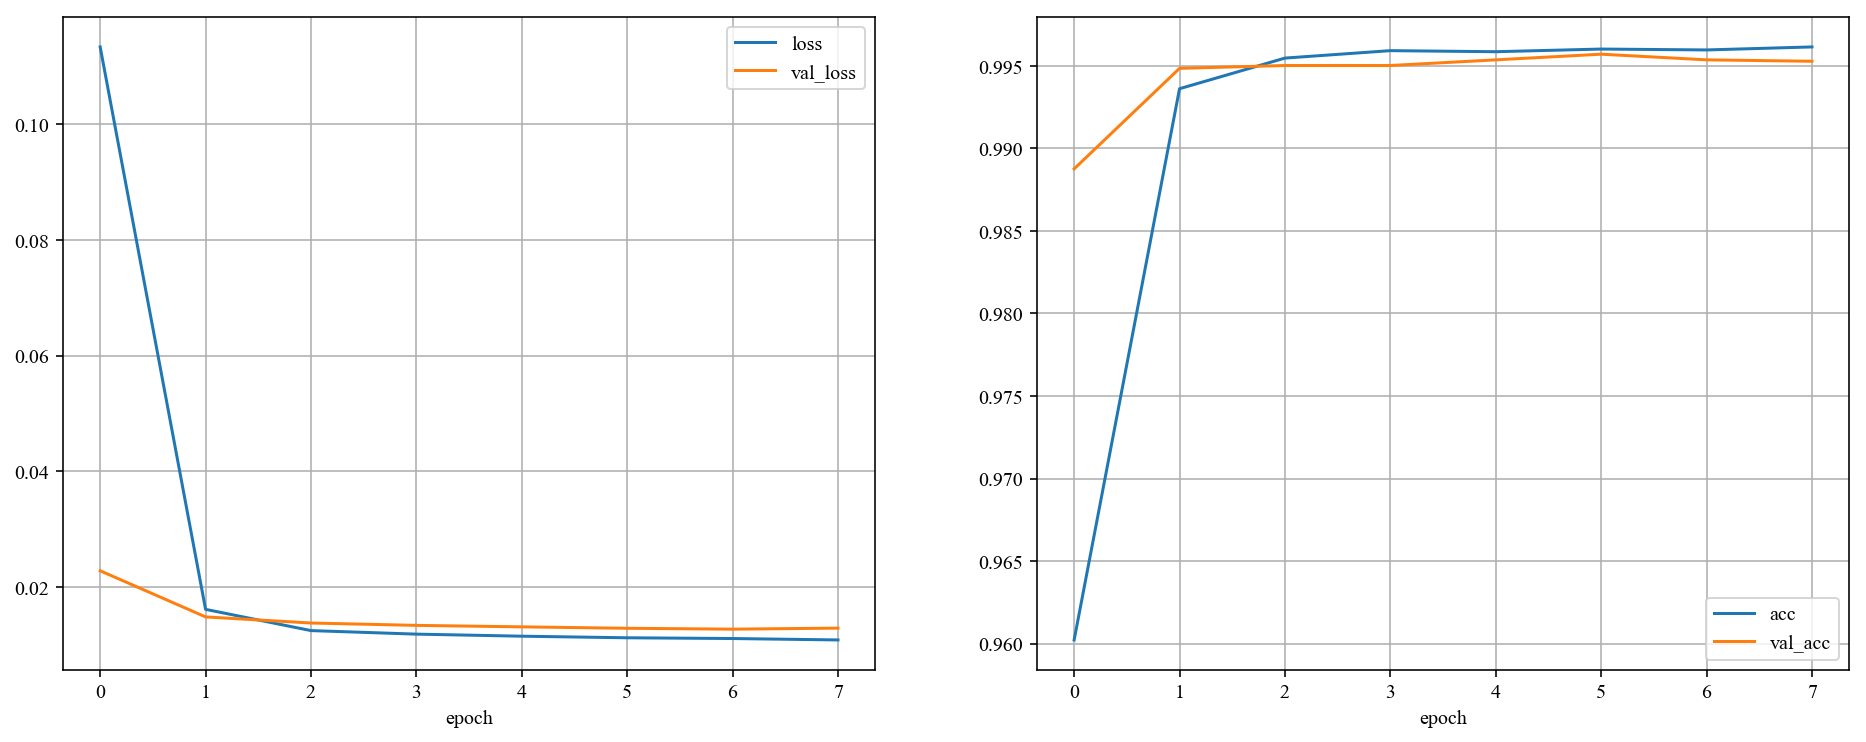

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [38]:
y_val_pred = model.predict(X_val)[:,1]
y_val_ = data['val_y'].values.squeeze()

In [39]:
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11525
          1       0.83      0.77      0.80       131

avg / total       1.00      1.00      1.00     11656

[[11505    20]
 [   30   101]]


In [49]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['brand', 'groupname', 'title', 'shelfdescr',
           'shortdescr', 'longdescr']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)

In [50]:
df_examine.sample(10)

,id1,brand,groupname,title,price,shelfdescr,shortdescr,longdescr,shipweight,length,...,groupname,title,price,shelfdescr,shortdescr,longdescr,shipweight,length,width,height
4661,7325,usrobotics,networking products,usrobotics usr5637 56k usb faxmodem for windows mac linux,49.99,controller based dongle form factor,nan,us robotics robotics 5637 56k usb modem usr5637 modems,0.0,7.8,...,networking,usrobotics 56k usb external modem,47.82,delivers superb performance and reliability in compact flexible form factor,the usrobotics 56k usb modem delivers superb performance and reliability in compact flexible form,key features broadly compatible across major operating systems including linux windows and macintosh quick connect reduces your connection time to get you online quicker upstream provides 50 greater upload speeds and is ideal for sending messages with large attachments supports usrobotics modem on hold application to screen incoming voice calls while online answer calls without losing your internet connection no second phone line is needed,0.600,7.600,6.00,1.500
9125,8092,tomtom,vehicle gps,tomtom via 1505t portable gps navigator with lifetime traffic,179.95,get over million more miles of mapped roads in the us outsmart delays with free lifetime traffic updates without advertising navigate with ease using premium maps of the us canada amp mexico travel in style with the new slim design and integrated fold and go easyport mount plan routes easily with smarter user interface on bright touchscreen,tomtom via 1505t portable gps navigator with lifetime traffic,the via story hit the road and the new tomtom via series holds the latest navigation technology in fresh sleek design including an integrated fold amp go easyport travel confidently with superior routing and the most accurate dependable maps in the gps in fact tomtom gives you one million more miles of mapped roads in the us the via range offers large array of unique lifetime traffic and map updates bluetooth calling and natural voice recognition with destination address at affordable the tomtom via 1505t introducing the tomtom via 1505t equipped with superior driving travel with ease and style throughout the us canada amp this innovative navigator boasts design classic finish new intuitive user interface and using tomtom maps you have access to one million more miles of mapped road in the us than you would using any other gps brand and with tomtom map share updates you can easily make instant changes and download verified updates from other tomtom users to y...,0.0,5.3,...,gps,tomtoim via 1505t,179.95,lcd widescreen 480 272 pixels spoken street names advanced lane guidance,the tomtom via 1505t portable gps boasts bright this innovative navigator also has super slim design classic finish and new intuitive user interface that will assist your travel throughout the us canada and mexico with ease and,tomtom via 1505t lcd widescreen 480 272 pixels presents information clearly and brightly for optimal navigation spoken street names announces directions includes us canada and mexico using tomtom premium maps on demand updates with the latest maps advanced lane guidance never miss your exit includes adhesive disk usb cable usb traffic receiver and home charging cable get started right out of the box battery lasts up to hours,1.100,7.000,6.90,1.900
11293,21732,v7,video cables,v7 dvi cable dual link male to male black feet,13.99,cable dvi to dvi v7 by belkin,nan,v7 dvi cable cables,0.0,10.8,...,electronics general,v7 replacement dvi cable by belkin,10.88,v7 dvi cables are designed and manufactured to meet and exceed all category specifications to ensure excellent connectors contacts nickel plated,v7 replacement dvi cable by belkin,v7 dvi cables are designed and manufactured to meet and exceed all category specifications to ensure excellent connectors contacts nickel plated,0.350,9.675,7.65,0.675
6184,19801,lanthem,printer ink toner,time vis6008 vis6008 ribbon purple lthvis6008,39.08,vis6

# Save model and histories 

In [40]:
pd.DataFrame(histories).to_csv('../data/histories/amazon-walmart-base-1-full.csv', index=False)
model.save_weights('../data/models/amazon-walmart-base-1-full')

# Test model 

In [5]:
model.load_weights('../data/models/amazon-walmart-base-1-full')
y_test_pred = model.predict(X_test)[:,1]
y_test_ = data['test_y'].values.squeeze()

In [6]:
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99758   0.99905   0.99831     11540
          1    0.88776   0.75652   0.81690       115

avg / total    0.99649   0.99665   0.99652     11655

[[11529    11]
 [   28    87]]
